In [34]:
import warnings
warnings.filterwarnings('ignore')

# Import Neccessary libraries
import numpy as np 
import pandas as pd 

# Import Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

#Import Sampler libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

In [35]:
diabetes_dataset = pd.read_csv("dataset/diabetes.csv")

In [36]:
diabetes_dataset.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [37]:
# Handle duplicates
diabetes_dataset = diabetes_dataset[diabetes_dataset.duplicated()]
print("number of duplicate rows: ", diabetes_dataset.shape)

number of duplicate rows:  (3854, 9)


In [38]:
diabetes_dataset = diabetes_dataset.drop_duplicates()

In [39]:
# Loop through each column and count the number of distinct values
for column in diabetes_dataset.columns:
    num_distinct_values = len(diabetes_dataset[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 2 distinct values
age: 84 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 26 distinct values
HbA1c_level: 17 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [40]:
# Checking null values
print(diabetes_dataset.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [41]:
# Remove Unneccessary value 
diabetes_dataset = diabetes_dataset[diabetes_dataset['gender'] != 'Other']

In [42]:
# data preparation
# Define a function to map the existing categories to new ones
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

# Apply the function to the 'smoking_history' column
diabetes_dataset['smoking_history'] = diabetes_dataset['smoking_history'].apply(recategorize_smoking)

# Check the new value counts
print(diabetes_dataset['smoking_history'].value_counts())

smoking_history
non-smoker     2865
past_smoker     135
current          85
Name: count, dtype: int64


In [43]:
def perform_one_hot_encoding(diabetes_dataset, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(diabetes_dataset[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    diabetes_dataset = pd.concat([diabetes_dataset.drop(column_name, axis=1), dummies], axis=1)

    return diabetes_dataset

# Perform one-hot encoding on the gender variable
diabetes_dataset = perform_one_hot_encoding(diabetes_dataset, 'gender')

# Perform one-hot encoding on the smoking history variable
diabetes_dataset = perform_one_hot_encoding(diabetes_dataset, 'smoking_history')

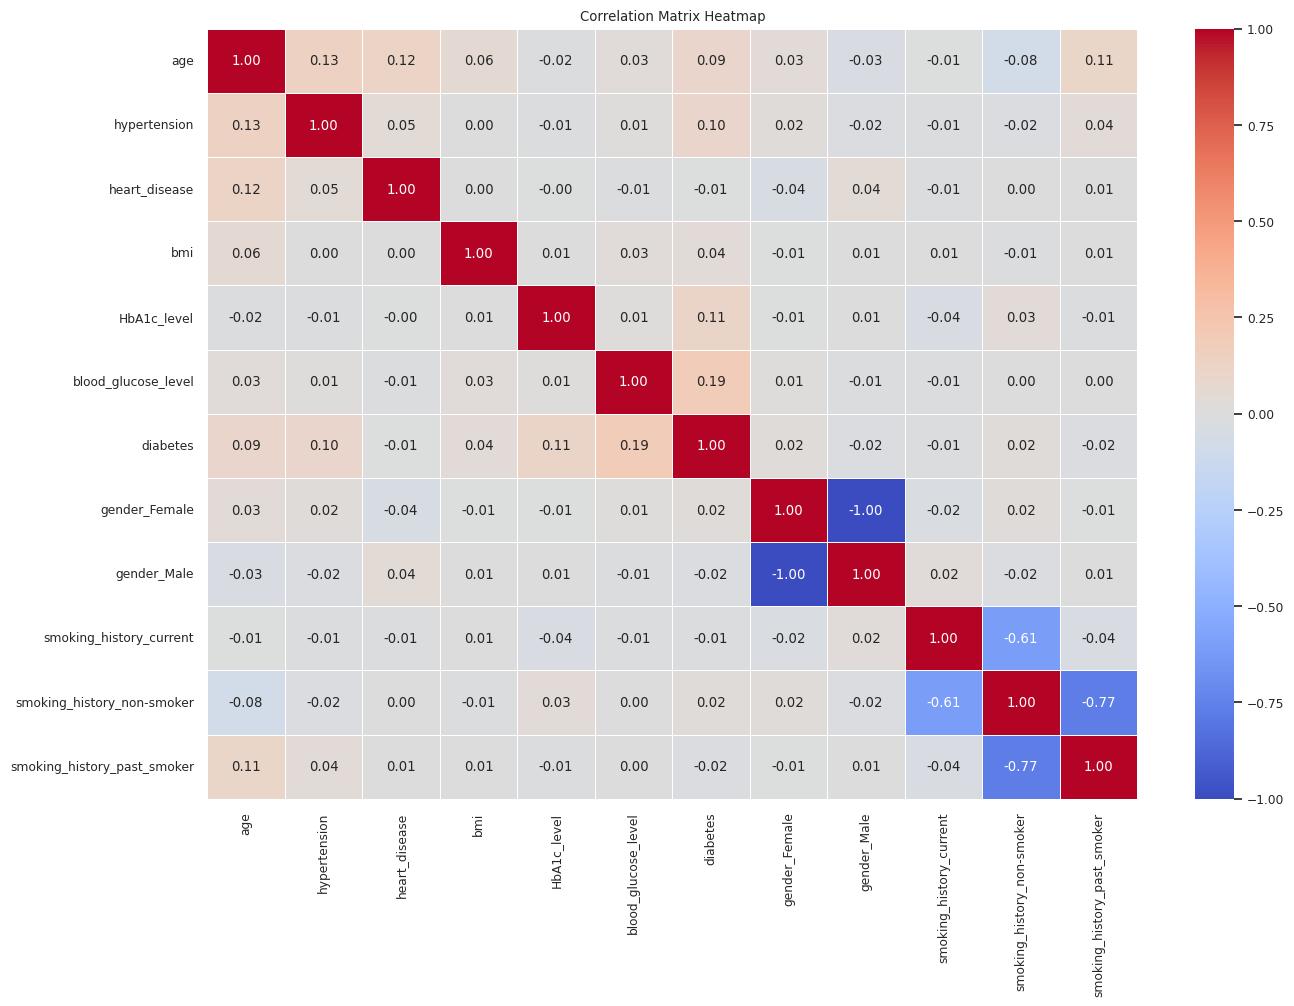

In [44]:
# Compute the correlation matrix
correlation_matrix = diabetes_dataset.corr()
#Graph I.
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Correlation Matrix Heatmap")
plt.show()

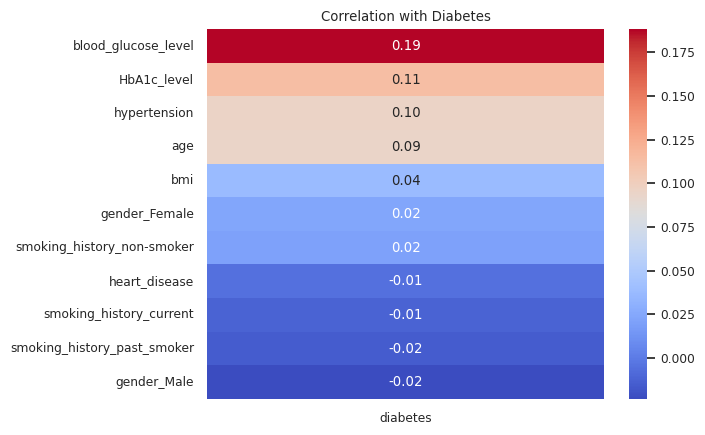

In [45]:
#Graph II
# Create a heatmap of the correlations with the target column
corr = diabetes_dataset.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

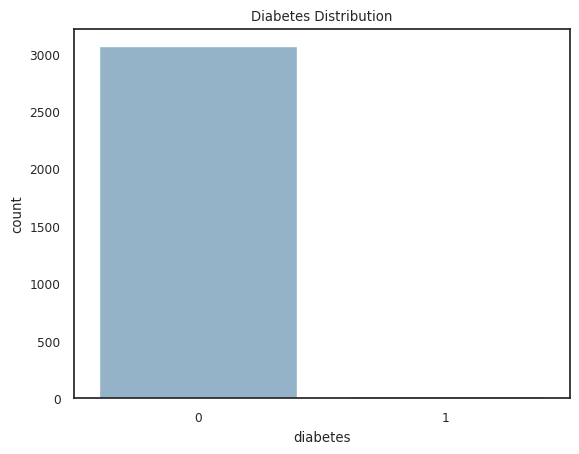

In [46]:
# Count plot for the 'diabetes' variable
sns.countplot(x='diabetes', data=diabetes_dataset)
plt.title('Diabetes Distribution')
plt.show()

In [47]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [48]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

# Split data into features and target variable
X = diabetes_dataset.drop('diabetes', axis=1)
y = diabetes_dataset['diabetes']

In [49]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [50]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [51]:
# Create Grid Search object
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

ValueError: 
All the 405 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'gender'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'gender'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 255, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/imblearn/pipeline.py", line 1104, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yeshey/anaconda3/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe
